# 1. Functions

In [1]:
def standardize(parameter):
    """
    :param parameter: the array with the parameters you wish to standardize
    :return param_mean: mean of the input array
    :return param_std : standard deviation of the input array
    :return stdized_param: final standardized array
    """
    import numpy as np
    
    param_mean    = np.mean(parameter)
    param_std     = np.std(parameter)
    stdized_param = []                  # standardized parameter -- output
    for i in range(parameter.size):
        param_temp = (parameter[i] - param_mean)/param_std
        stdized_param.append(param_temp)
    stdized_param = np.array(stdized_param)
    return (param_mean, param_std, stdized_param)

In [2]:
def un_standardize(stdized_par, mean, std):
    """
    This function undoes what the former does!
    """
    
    import numpy as np
    
    recovered_par = []
    for i in range(stdized_par.size):
        param_temp = stdized_par[i]*std + mean
        recovered_par.append(param_temp)
    recovered_par = np.array(recovered_par)
    return (recovered_par)

In [3]:
def print_time(begin_time, end_time):
    """ 
    This function prints the time in minutes that a certain task took.
    """
    print ("--------------------------------------------------")
    print ("CPU process time: %.2f [min]" % float((end-start)/60))
    print ("--------------------------------------------------")

# 2. Packages

In [4]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import statsmodels.api   as sm
import seaborn           as sns
import arviz
import pystan
import time

In [5]:
my_data = pd.read_csv('../../Catalogue/binom_reg_dataset.csv')

In [6]:
# filtering the dataset
redshifts = my_data['Z']
index     = np.where(redshifts.values<=0.4)

logit_class = my_data['LOGIT_CLASS(1-UVUP;0-UVWEAK)'].values.astype(int)    # y axis: logit class: UVUP yes/no
whan_class  = my_data['WHAN(0-NA;1-RP;2-wA;3-sA;4-SF)'].values.astype(int)  # My types of galaxies
mass        = my_data['STELLAR_MASS'].values.astype(float)                  # 1st parameter
redshift    = redshifts.values.astype(float)                                # 2nd parameter

In [7]:
# original parameters
mean_mass, std_mass, x2 = standardize(mass)
x1      = redshift
y       = logit_class
classes = (whan_class+1).astype(int)        # Must sum +1 to avoid index issues with STAN
n_obs   = x1.size
n_class = np.unique(classes).size

# new parameters - important for plotting!
n_obs2 = 30
x1_sim = np.linspace(x1.min(), x1.max(), n_obs2)
x2_sim = np.linspace(x2.min(), x2.max(), n_obs2)

# grid
plot_x1, plot_x2 = np.meshgrid(x1_sim, x2_sim)  # THIS IS WHERE THE GRID IS DONE
plot_x1 = plot_x1.reshape((n_obs2**2), 1)
plot_x2 = plot_x2.reshape((n_obs2**2), 1)

In [8]:
# dataset to be used in the regression
regression_data      = {}                                                 # Dictionary, as stated in the pystan manual
regression_data['Y'] = y
regression_data['X'] = sm.add_constant(np.column_stack((x1, x1**2, x2, x2**2)))
regression_data['K'] = regression_data['X'][0,:].size                     # Number of betas -- b0, b1, b2, b3, b4
regression_data['W'] = classes
regression_data['N'] = n_obs
regression_data['C'] = n_class                                       # Number of different classes (partial pooling)

# dataset to be used in the plot -- after meshgrid
regression_data['X2'] = sm.add_constant(np.column_stack((plot_x1, plot_x1**2, plot_x2, plot_x2**2)))
regression_data['N2'] = n_obs2**2

In [9]:
regression_data['X']

array([[ 1.        ,  0.13198   ,  0.01741872, -1.70357426,  2.90216527],
       [ 1.        ,  0.1387    ,  0.01923769,  0.10514058,  0.01105454],
       [ 1.        ,  0.17168   ,  0.02947402,  0.31574997,  0.09969804],
       ...,
       [ 1.        ,  0.20231   ,  0.04092934,  1.26951465,  1.61166744],
       [ 1.        ,  0.20539   ,  0.04218505,  0.55460043,  0.30758164],
       [ 1.        ,  0.18752   ,  0.03516375,  0.30177561,  0.09106852]])

/home/mlldantas/anaconda3/envs/py3k6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


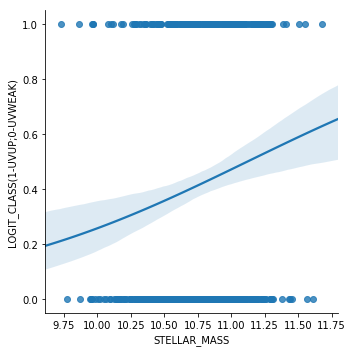

In [10]:
# plt.plot(redshifts, logit_class, '.')
sns.lmplot(x='STELLAR_MASS', y='LOGIT_CLASS(1-UVUP;0-UVWEAK)', data=my_data.iloc[index], logistic=True)
# plt.savefig('../../LargeFilesResults/Model/logistic_seaborn.pdf')
plt.show()

### 2.1 Fit: STAN code 

In [11]:
stan_code = """
// DECLARATION OF VARIABLES ------------------------------------------------------------------------------------------
data{
    int<lower=1> N;
    int<lower=1> N2;
    int<lower=1> K;
    int<lower=1> C;
    int W[N];
    int<lower=0, upper=1> Y[N];
    matrix[N, K] X;         // redshift and stellar mass 
    matrix[N2,K] X2;        // redshift and stellar mass -- after grid
    }

// DEFINING THE PRIOR(S) ---------------------------------------------------------------------------------------------
parameters{
    matrix[K,C] beta;       // 25 betas!
    real<lower=0> sigma;    // Shared hyperpriors
    real mu;                // Shared hyperpriors
    }

// MODEL: PROBABILITY, HYPERPRIORS, PRIORS, AND REGRESSION -----------------------------------------------------------
model {
   vector[N] prob;
    for (i in 1:N) {
      prob[i] = beta[1,W[i]]*X[i,1] + beta[2,W[i]]*X[i,2] + beta[3,W[i]]*X[i,3] + beta[4,W[i]]*X[i,4] + 
      beta[5,W[i]]*X[i,5];
      }

    sigma ~ gamma(0.001, 0.001);                           // shared hyperpriors
    mu ~ normal(0, 100);                                   // shared hyperpriors
     
    for (i in 1:K) {
       for (j in 1:C) beta[i,j] ~ normal(mu, sigma);       // priors
        }

    Y ~ bernoulli_logit(prob);                             // regression
    }

// DATA TO BE PLOTTED ------------------------------------------------------------------------------------------------
generated quantities{
    vector[N2] prob01;
    vector[N2] eta01;
    vector[N2] prob02;
    vector[N2] eta02;
    vector[N2] prob03;
    vector[N2] eta03;
    vector[N2] prob04;
    vector[N2] eta04;
    vector[N2] prob05;
    vector[N2] eta05;
    
    for(j in 1:N2){
        eta01[j] = beta[1,1]*X2[j,1] + beta[2,1]*X2[j,2] + beta[3,1]*X2[j,3] + beta[4,1]*X2[j,4] + beta[5,1]*X2[j,5];
        eta02[j] = beta[1,2]*X2[j,1] + beta[2,2]*X2[j,2] + beta[3,2]*X2[j,3] + beta[4,2]*X2[j,4] + beta[5,2]*X2[j,5];
        eta03[j] = beta[1,3]*X2[j,1] + beta[2,3]*X2[j,2] + beta[3,3]*X2[j,3] + beta[4,3]*X2[j,4] + beta[5,3]*X2[j,5];
        eta04[j] = beta[1,4]*X2[j,1] + beta[2,4]*X2[j,2] + beta[3,4]*X2[j,3] + beta[4,4]*X2[j,4] + beta[5,4]*X2[j,5];
        eta05[j] = beta[1,5]*X2[j,1] + beta[2,5]*X2[j,2] + beta[3,5]*X2[j,3] + beta[4,5]*X2[j,4] + beta[5,5]*X2[j,5];
        prob01[j] = inv_logit(eta01[j]);
        prob02[j] = inv_logit(eta02[j]);
        prob03[j] = inv_logit(eta03[j]);
        prob04[j] = inv_logit(eta04[j]);
        prob05[j] = inv_logit(eta05[j]);
        }

    }

"""

### 2.2 Fit settings (for STAN)

In [12]:
iterations = 5000
chains     = 3                           # HMC chains
warmup     = 2000                        # How many of the first iterations we'll ignore - burnin
jobs       = -1                          # Run code in parallel -- see pystan documentation
seed       = 1

In [13]:
control = {}
control['max_treedepth'] = 30
control['adapt_delta'] = 0.99

### 2.3 Running the fit

In [14]:
start = time.time()

model = pystan.StanModel(model_code=stan_code)

end = time.time()
print_time(start, end)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_50fd202ecaf8992b685aa66bc38cb07a NOW.


--------------------------------------------------
CPU process time: 1.14 [min]
--------------------------------------------------


In [15]:
start = time.time()

fit = model.sampling(data=regression_data, seed=seed, iter=iterations, chains=chains, warmup=warmup, n_jobs=jobs, 
                     control=control)
end = time.time()
print_time(start, end)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


--------------------------------------------------
CPU process time: 1.15 [min]
--------------------------------------------------


# 3. Retrieving the data from the fit

### 3.1 Saving the entire fit: brace for impact!

In [16]:
start  = time.time()
fit_df = fit.to_dataframe()
end    = time.time()
print_time(start, end)

--------------------------------------------------
CPU process time: 0.05 [min]
--------------------------------------------------


In [17]:
start = time.time()
fit_df.to_csv('../../LargeFilesResults/Model/entirefit_shared_revised.csv', index=False)
end   = time.time()
print_time(start, end)

--------------------------------------------------
CPU process time: 2.83 [min]
--------------------------------------------------


In [18]:
posteriors = fit_df[fit.flatnames[:25]]
header_posteriors = fit.flatnames[:25]

In [19]:
manual_list = [fit['beta[1,1]'], fit['beta[2,1]'], fit['beta[3,1]'], fit['beta[4,1]'], fit['beta[5,1]'],  
               fit['beta[1,2]'], fit['beta[2,2]'], fit['beta[3,2]'], fit['beta[4,2]'], fit['beta[5,2]'],
               fit['beta[1,3]'], fit['beta[2,3]'], fit['beta[3,3]'], fit['beta[4,3]'], fit['beta[5,3]'],
               fit['beta[1,4]'], fit['beta[2,4]'], fit['beta[3,4]'], fit['beta[4,4]'], fit['beta[5,4]'],
               fit['beta[1,5]'], fit['beta[2,5]'], fit['beta[3,5]'], fit['beta[4,5]'], fit['beta[5,5]']]

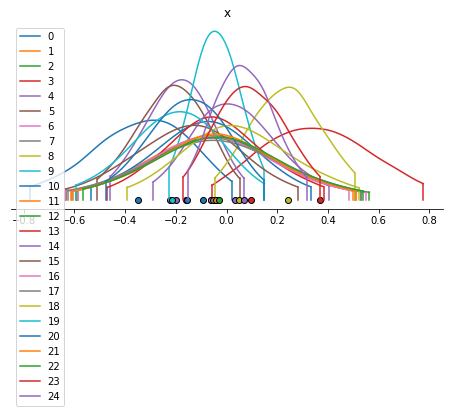

In [20]:
arviz.plot_density(data=manual_list)
plt.show()

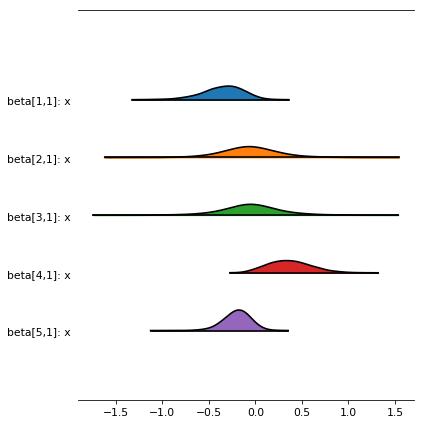

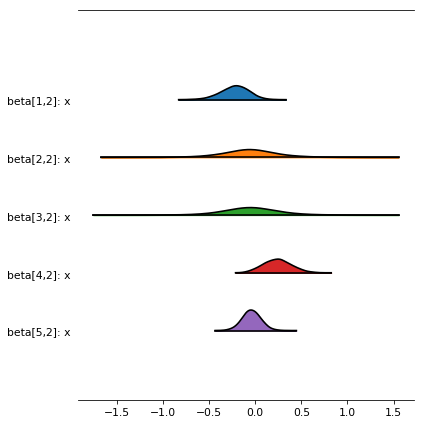

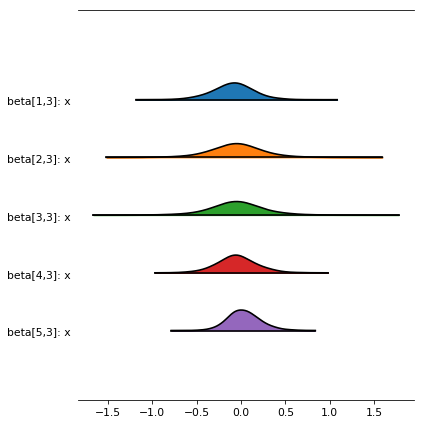

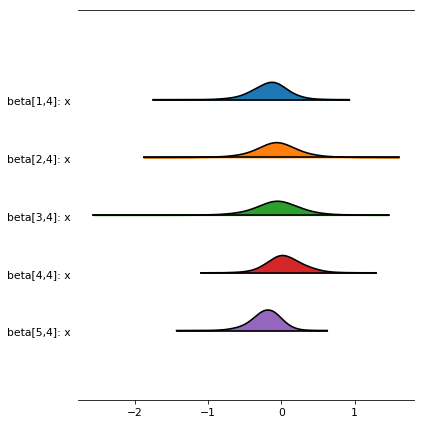

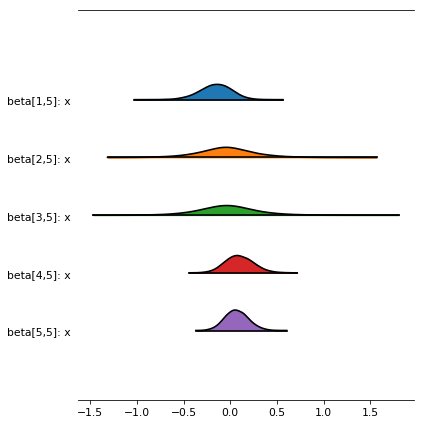

In [21]:
arviz.plot_forest(data=[fit['beta[1,1]'], fit['beta[2,1]'], fit['beta[3,1]'], fit['beta[4,1]'], fit['beta[5,1]']], 
                  kind='ridgeplot', model_names=['beta[1,1]', 'beta[2,1]', 'beta[3,1]', 'beta[4,1]', 'beta[5,1]'],
                  r_hat=False, n_eff=False, figsize=(6,6))
plt.tight_layout()
plt.savefig('../../LargeFilesResults/Model/betas_shared_forest01.png', dpi=150, bbox_inches='tight')

arviz.plot_forest(data=[fit['beta[1,2]'], fit['beta[2,2]'], fit['beta[3,2]'], fit['beta[4,2]'], fit['beta[5,2]']], 
                  kind='ridgeplot', model_names=['beta[1,2]', 'beta[2,2]', 'beta[3,2]', 'beta[4,2]', 'beta[5,2]'], 
                  r_hat=False, n_eff=False, figsize=(6,6))
plt.tight_layout()
plt.savefig('../../LargeFilesResults/Model/betas_shared_forest02.png', dpi=150, bbox_inches='tight')
plt.show()

arviz.plot_forest(data=[fit['beta[1,3]'], fit['beta[2,3]'], fit['beta[3,3]'], fit['beta[4,3]'], fit['beta[5,3]']], 
                  kind='ridgeplot', model_names=['beta[1,3]', 'beta[2,3]', 'beta[3,3]', 'beta[4,3]', 'beta[5,3]'], 
                  r_hat=False, n_eff=False, figsize=(6,6))
plt.tight_layout()
plt.savefig('../../LargeFilesResults/Model/betas_shared_forest03.png', dpi=150, bbox_inches='tight')
plt.show()

arviz.plot_forest(data=[fit['beta[1,4]'], fit['beta[2,4]'], fit['beta[3,4]'], fit['beta[4,4]'], fit['beta[5,4]']], 
                  kind='ridgeplot', model_names=['beta[1,4]', 'beta[2,4]', 'beta[3,4]', 'beta[4,4]', 'beta[5,4]'],  
                  r_hat=False, n_eff=False, figsize=(6,6))
plt.tight_layout()
plt.savefig('../../LargeFilesResults/Model/betas_shared_forest04.png', dpi=150, bbox_inches='tight')
plt.show()

arviz.plot_forest(data=[fit['beta[1,5]'], fit['beta[2,5]'], fit['beta[3,5]'], fit['beta[4,5]'], fit['beta[5,5]']], 
                  kind='ridgeplot', model_names=['beta[1,5]', 'beta[2,5]', 'beta[3,5]', 'beta[4,5]', 'beta[5,5]'],  
                  r_hat=False, n_eff=False, figsize=(6,6))
plt.tight_layout()
plt.savefig('../../LargeFilesResults/Model/betas_shared_forest05.png', dpi=150, bbox_inches='tight')
plt.show()

In [22]:
figsize=(6,3)

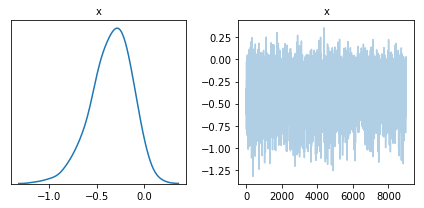

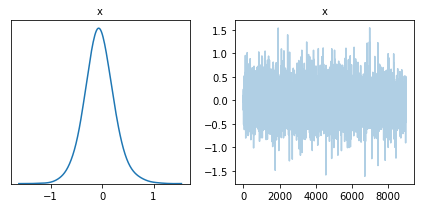

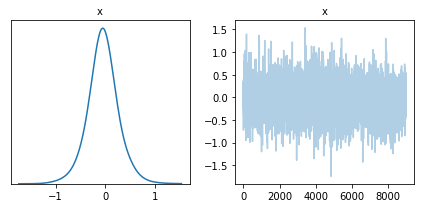

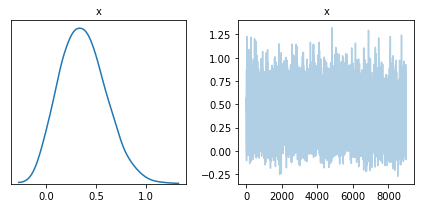

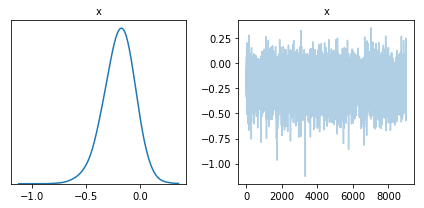

In [23]:
plot = arviz.plot_trace(data=fit['beta[1,1]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[2,1]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[3,1]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[4,1]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[5,1]'], figsize=figsize)
plt.tight_layout()
# plt.savefig('../../LargeFilesResults/Model/trace_class01.pdf', bbox_inches='tight')
plt.show()

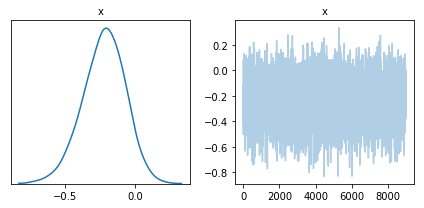

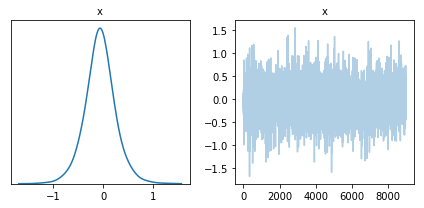

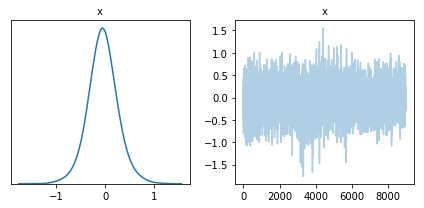

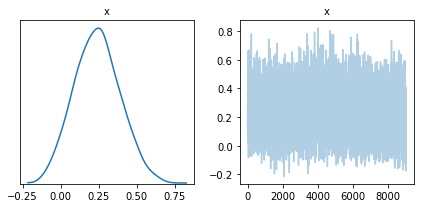

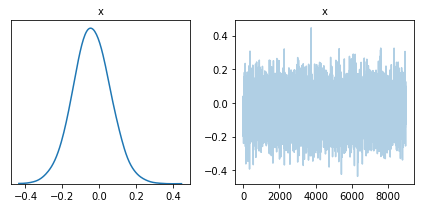

In [24]:
plot = arviz.plot_trace(data=fit['beta[1,2]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[2,2]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[3,2]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[4,2]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[5,2]'], figsize=figsize)
plt.tight_layout()
# plt.savefig('../../LargeFilesResults/Model/trace_class02.pdf', bbox_inches='tight')
plt.show()

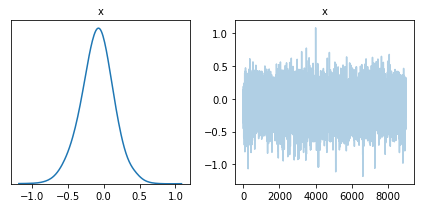

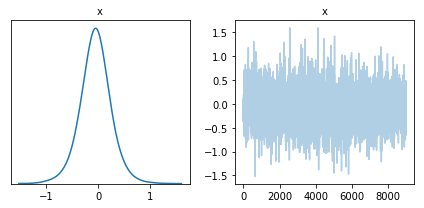

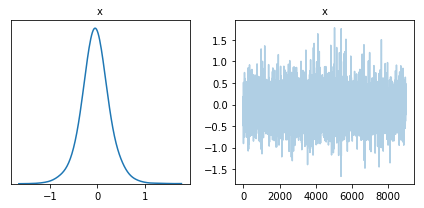

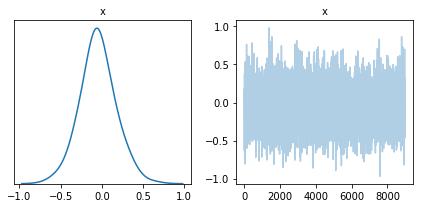

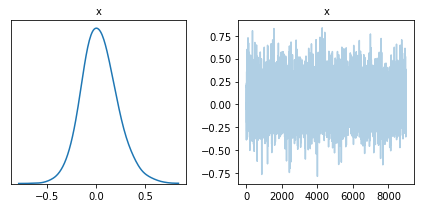

In [25]:
plot = arviz.plot_trace(data=fit['beta[1,3]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[2,3]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[3,3]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[4,3]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[5,3]'], figsize=figsize)
plt.tight_layout()
# plt.savefig('../../LargeFilesResults/Model/trace_class03.pdf', bbox_inches='tight')
plt.show()

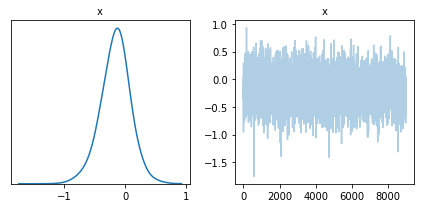

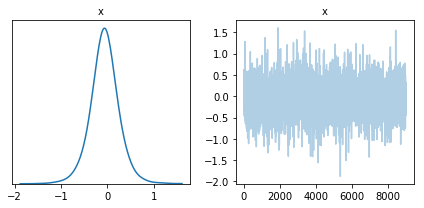

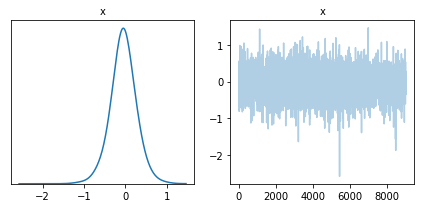

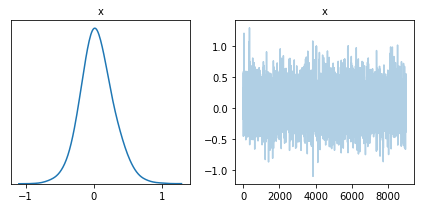

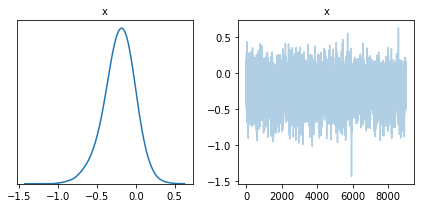

In [26]:
plot = arviz.plot_trace(data=fit['beta[1,4]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[2,4]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[3,4]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[4,4]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[5,4]'], figsize=figsize)
# plt.savefig('../../LargeFilesResults/Model/trace_class04.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

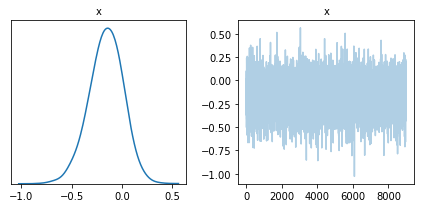

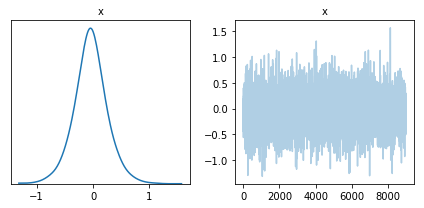

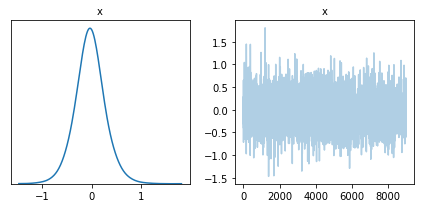

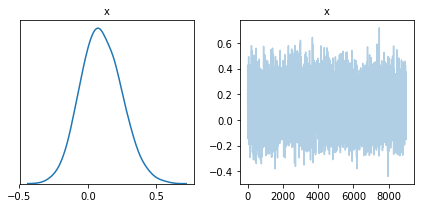

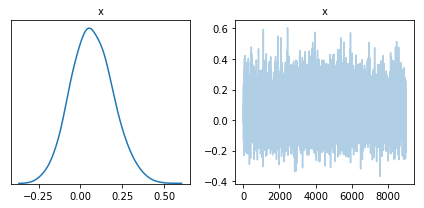

In [27]:
plot = arviz.plot_trace(data=fit['beta[1,5]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[2,5]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[3,5]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[4,5]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[5,5]'], figsize=figsize)
# plt.savefig('../../LargeFilesResults/Model/trace_class05.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

### 3.2 Saving the automatic summary from STAN

In [28]:
summary = pystan.stansummary(fit=fit, digits_summary=5)

In [29]:
summary_arr  = np.array(summary.split('\n'))
summay_clean = summary_arr[5:-6,]

In [30]:
header_fit = ['parameter'] + summary_arr[4].split()

#### 3.2.1 Recovering the mass (undo the stadardization) and adding x1 and x2 to the summary

In [31]:
recovered_mass  = un_standardize(stdized_par=plot_x2, mean=mean_mass, std=std_mass)
recovered_pars  = np.column_stack((np.squeeze(plot_x1), np.squeeze(recovered_mass)))
rp      = recovered_pars
rp_cols = np.vstack((rp, rp, rp, rp, rp))    # for 5 whan classes we must stack these 5x

In [32]:
rp_cols

array([[ 0.06794   ,  9.729482  ],
       [ 0.08488862,  9.729482  ],
       [ 0.10183724,  9.729482  ],
       ...,
       [ 0.52555276, 11.67857   ],
       [ 0.54250138, 11.67857   ],
       [ 0.55945   , 11.67857   ]])

#### 3.2.2 Checking if the numbers aren't overlaped

In [33]:
new_summary = list(np.zeros(len(header_fit)))
for i in range(summay_clean.size):
    if len(summay_clean[i].split())!=11:   # the length of the list must be 11, in which case we connect them directly
        print (i, summay_clean[i])
    else:
        new_summ_temp = np.array(summay_clean[i].split()).reshape(1,11)
        new_summary   = np.vstack((new_summary, new_summ_temp))
new_summary = new_summary[1:,:]            # removing the zeroes in the beggining
print (new_summary[:,0].shape)

(9027,)


In [ ]:
# new_summary[6490] = 'eta04[164]  -0.618  0.0150 1.0190 -2.943 -1.148 -0.472 -6.7372e-6 1.1647   4598 1.0004'
# new_summary[3141] = 'eta02[415]  -0.325  0.0075 0.1861 -0.706 -0.451 -0.319 -0.189 7.666e-5    618 1.0033'
# new_summary[5357] = 'eta03[831]  0.0156  0.0036 0.4035 -0.770 -0.239 -2.358e-5 0.2623 0.8554  12314 1.0004'
# new_summary[6490] = 'eta04[164]  -0.619   0.015 1.0191 -2.943 -1.148 -0.472 -6.737e-6 1.1647   4598 1.0005'
# new_summary[8853] = 'eta05[727]  -0.136  0.0035 0.2068 -0.590 -0.254 -0.118 3.144e-5 0.2253   3419  1.001'

#### 3.2.3 Retrieving only the probabilities from the summary and stacking x1 and x2 at the end of the dataframe

In [34]:
parameters = new_summary[:,0].astype(str)
pnew_idxs  = []
for i in range(parameters.size):
    if parameters[i][0:4]=='prob':
        pnew_idxs.append(i)
    else:
        continue
print (new_summary[pnew_idxs,:].shape, rp_cols.shape)
model_results    = np.column_stack((new_summary[pnew_idxs,:], rp_cols))
model_results_df = pd.DataFrame(model_results)
model_results_df.columns = header_fit + ['Z'] + ['LOG_STELLAR_MASS']
model_results_df.index = model_results_df['parameter']
model_results_df = model_results_df.drop(columns='parameter', axis=1)
model_results_df.to_csv('../../LargeFilesResults/Model/fit_summary_shared_revised.csv', header=True, index=True)

(4500, 11) (4500, 2)


In [35]:
model_results_df

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat,Z,LOG_STELLAR_MASS
parameter,,,,,,,,,,,,
prob01[1],0.0761,0.0016,0.0905,0.0012,0.0150,0.0432,0.1019,0.3297,2941,1.0013,0.06794,9.729482
prob01[2],0.0760,0.0016,0.0904,0.0012,0.0150,0.0431,0.1018,0.3296,2941,1.0013,0.08488862068965516,9.729482
prob01[3],0.0760,0.0016,0.0903,0.0012,0.0150,0.0431,0.1017,0.3292,2942,1.0013,0.10183724137931034,9.729482
prob01[4],0.0759,0.0016,0.0902,0.0012,0.0150,0.0431,0.1015,0.3283,2942,1.0013,0.11878586206896552,9.729482
prob01[5],0.0758,0.0016,0.0901,0.0012,0.0150,0.0429,0.1014,0.3282,2943,1.0013,0.13573448275862068,9.729482
prob01[6],0.0757,0.0016,0.0900,0.0012,0.015,0.0429,0.1013,0.3283,2945,1.0013,0.15268310344827585,9.729482
prob01[7],0.0757,0.0016,0.0899,0.0012,0.0149,0.0427,0.1012,0.3278,2946,1.0013,0.16963172413793104,9.729482
prob01[8],0.0756,0.0016,0.0899,0.0012,0.0149,0.0427,0.1010,0.3277,2947,1.0013,0.1865803448275862,9.729482
prob01[9],0.0755,0.0016,0.0898,0.0012,0.0149,0.0427,0.1007,0.3275,2949,1.0013,0.20352896551724137,9.729482


In [36]:
posteriors = fit_df[fit.flatnames[:25]]

In [37]:
fit_df.keys()

Index(['chain', 'draw', 'warmup', 'beta[1,1]', 'beta[2,1]', 'beta[3,1]',
       'beta[4,1]', 'beta[5,1]', 'beta[1,2]', 'beta[2,2]',
       ...
       'eta05[898]', 'eta05[899]', 'eta05[900]', 'lp__', 'accept_stat__',
       'stepsize__', 'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__'],
      dtype='object', length=9037)

In [38]:
fit_df['treedepth__'].describe()

count    9000.000000
mean        5.655889
std         1.057377
min         3.000000
25%         5.000000
50%         5.000000
75%         7.000000
max         8.000000
Name: treedepth__, dtype: float64

In [39]:
fit_df['n_leapfrog__'].describe()

count    9000.000000
mean       70.136889
std        54.629898
min         7.000000
25%        31.000000
50%        47.000000
75%       127.000000
max       255.000000
Name: n_leapfrog__, dtype: float64

In [40]:
posteriors.to_csv('../../LargeFilesResults/Model/posteriors_shared_revised.csv', index=False)

In [41]:
posteriors

,"beta[1,1]","beta[2,1]","beta[3,1]","beta[4,1]","beta[5,1]","beta[1,2]","beta[2,2]","beta[3,2]","beta[4,2]","beta[5,2]",...,"beta[1,4]","beta[2,4]","beta[3,4]","beta[4,4]","beta[5,4]","beta[1,5]","beta[2,5]","beta[3,5]","beta[4,5]","beta[5,5]"
0,-0.765527,-0.260241,0.723316,0.880719,-0.166593,-0.389637,0.570236,-0.135351,0.498534,0.052757,...,-0.328292,0.282157,0.657681,0.292521,-0.078229,0.150645,0.351454,0.450076,0.097130,0.145485
1,-0.917010,-0.372873,0.912745,0.420295,0.262984,-0.284245,0.660314,-0.060090,0.249914,-0.161167,...,-0.252545,-0.149872,-0.216154,0.624387,0.207880,-0.164104,0.196985,0.561816,0.045085,-0.303639
2,-0.393573,-0.302602,0.334868,0.771745,0.076760,-0.289697,0.673628,-0.328673,0.264463,-0.061561,...,-0.033734,-0.213372,0.531514,0.082322,0.089716,-0.463409,0.306404,0.707031,0.207714,0.137524
3,-0.097784,0.444572,0.059231,0.611717,-0.280112,-0.316411,-0.638046,0.676410,0.283705,0.098084,...,-0.241240,0.402825,-0.279118,-0.007610,-0.622778,-0.212992,-0.406637,-0.641996,0.140382,0.152417
4,-0.641871,-0.084189,0.568076,0.357966,-0.221401,-0.310553,-0.202260,-0.328146,0.190234,-0.047770,...,-0.194790,-0.303797,0.118629,0.101513,-0.415347,-0.099474,-0.362537,-0.208663,-0.010256,0.132645
5,-0.044329,-0.604144,-0.614313,0.611843,-0.243954,-0.427339,0.107429,0.197912,0.368143,0.083967,...,0.093698,-0.048006,-0.158875,0.306268,-0.027671,-0.182210,-0.537559,-0.149216,0.323971,0.088233
6,-0.791204,0.605062,0.689829,0.329441,-0.105265,-0.030153,-0.047121,-0.167732,0.272209,-0.090926,...,-0.462044,-0.005101,0.387007,-0.145495,-0.261662,-0.240496,0.511633,0.188198,-0.010285,0.059169
7,-0.638207,0.250119,0.216296,0.228911,-0.072629,-0.019003,-0.144120,-0.442510,0.176118,-0.226152,...,-0.367427,-0.234529,0.148190,-0.342946,-0.241121,-0.383241,0.144496,-0.200574,-0.085527,0.415982
8,-0.611795,0.099453,0.212553,0.262878,-0.174850,-0.099139,-0.266734,-0.420921,0.276275,-0.234897,...,-0.404513,-0.234445,0.327179,-0.328474,-0.358497,-0.446592,0.072093,-0.371828,0.025735,0.375608
9,-0.270081,0.283182,0.138307,0.337778,-0.227538,-0.153234,-0.054444,-0.321666,0.260955,-0.267790,...,-0.236569,-0.429062,0.066622,-0.157273,-0.196303,-0.321346,-0.076633,0.152586,-0.093438,0.296249


In [42]:
diagnostics = pystan.check_hmc_diagnostics(fit, per_chain=True)

In [43]:
diagnostics

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [44]:
pystan.check_hmc_diagnostics??

In [45]:
model_results_df['Rhat'].max()

'1.0049'

In [46]:
model_results_df['Rhat'].min()

'0.9997'